In [ ]:
! pip install keras-tuner
! pip install -q pyyaml h5py

In [127]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import seaborn as sns
import numpy as np
import kerastuner as kt
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from google.colab import files

In [128]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

np.set_printoptions(precision=3, suppress=True)

In [137]:
bike_data = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv")


In [138]:
# clean data
bike_data = bike_data.dropna()
bike_data.head()

,Unnamed: 0,instant,dteday,season,hr,holiday,workingday,weathersit,hum,windspeed,temp_c,feels_like_c,casual,registered
0,0,1,1/1/11,1,0,0,0,1,0.81,0,3.28,3.0014,3,13
1,1,2,1/1/11,1,1,0,0,1,0.80,0,2.34,1.9982,8,32
2,2,3,1/1/11,1,2,0,0,1,0.80,0,2.34,1.9982,5,27
3,3,4,1/1/11,1,3,0,0,1,0.75,0,3.28,3.0014,3,10
4,4,5,1/1/11,1,4,0,0,1,0.75,0,3.28,3.0014,0,1


In [139]:
# get the features that we want
wanted_features = ["season", "hr", "holiday", "workingday", "weathersit", "hum", "windspeed", "temp_c", "feels_like_c", "registered", "casual"]
bike_data = bike_data[wanted_features]

# convert season and weathersit to one hot
bike_data["season"] = bike_data["season"].map({1:"winter", 2:"spring", 3:"summer", 4:"fall"})
bike_data["weathersit"] = bike_data["weathersit"].map({1:"clear_weather", 2:"misty_weather", 3:"rainy_weather", 4:"severe_weather"})

bike_data.head()

,season,hr,holiday,workingday,weathersit,hum,windspeed,temp_c,feels_like_c,registered,casual
0,winter,0,0,0,clear_weather,0.81,0,3.28,3.0014,13,3
1,winter,1,0,0,clear_weather,0.80,0,2.34,1.9982,32,8
2,winter,2,0,0,clear_weather,0.80,0,2.34,1.9982,27,5
3,winter,3,0,0,clear_weather,0.75,0,3.28,3.0014,10,3
4,winter,4,0,0,clear_weather,0.75,0,3.28,3.0014,1,0


In [ ]:
bike_data = pd.get_dummies(bike_data, prefix='', prefix_sep='').astype(dtype="float32")

In [136]:
bike_data.head()

,hr,holiday,workingday,hum,windspeed,temp_c,feels_like_c,registered,casual,fall,spring,summer,winter,clear_weather,misty_weather,rainy_weather,severe_weather
0,0.0,0.0,0.0,0.81,0.0,3.28,3.0014,13.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.80,0.0,2.34,1.9982,32.0,8.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.80,0.0,2.34,1.9982,27.0,5.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.75,0.0,3.28,3.0014,10.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.75,0.0,3.28,3.0014,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [ ]:
# split into training and testing datasets randomly
train_dataset = bike_data.sample(frac=0.8, random_state=0)
test_dataset = bike_data.drop(train_dataset.index)

In [ ]:
# inspect the data
print(train_dataset.describe().transpose())
print("median registered bikes in a day: {}".format(train_dataset["registered"].median()))



                  count        mean  ...         75%         max
hr              13903.0   11.567360  ...   18.000000   23.000000
holiday         13903.0    0.028699  ...    0.000000    1.000000
workingday      13903.0    0.682299  ...    1.000000    1.000000
hum             13903.0    0.628884  ...    0.780000    1.000000
windspeed       13903.0   12.732504  ...   17.000000   57.000000
temp_c          13903.0   15.346667  ...   23.020000   38.060001
feels_like_c    13903.0   15.389220  ...   24.999201   48.996799
registered      13903.0  154.440842  ...  221.000000  886.000000
casual          13903.0   35.711861  ...   48.000000  367.000000
fall            13903.0    0.244480  ...    0.000000    1.000000
spring          13903.0    0.254981  ...    1.000000    1.000000
summer          13903.0    0.256995  ...    1.000000    1.000000
winter          13903.0    0.243545  ...    0.000000    1.000000
clear_weather   13903.0    0.653384  ...    1.000000    1.000000
misty_weather   13903.0  

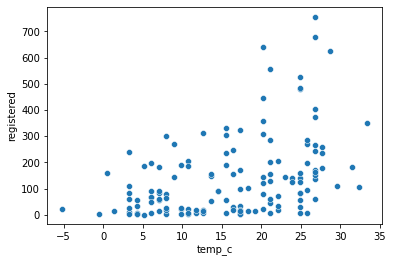

In [98]:
# plot some data
sns.scatterplot(data=train_dataset.sample(frac=0.01, random_state=1), x="temp_c", y="registered")


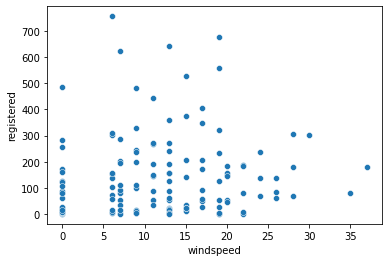

In [99]:
# plot more data
sns.scatterplot(data=train_dataset.sample(frac=0.01, random_state=1), x="windspeed", y="registered")

In [ ]:
# split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('registered')
test_labels = test_features.pop('registered')

In [ ]:
# build the normalizer
normalizer = Normalization()
normalizer.adapt(np.array(train_features))


In [144]:
# build the model
def model_builder():
  model = tf.keras.Sequential()
  model.add(normalizer)
  model.add(Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.0001)))
  model.add(Dropout(0.18))
  model.add(Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.0001)))
  model.add(Dropout(0.18))
  model.add(Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.0001)))
  model.add(Dropout(0.18))
  model.add(Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.0001)))
  model.add(Dropout(0.18))
  model.add(Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.0001)))
  model.add(Dropout(0.18))
  model.add(Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.0001)))
  model.add(Dropout(0.18))
  model.add(Dense(1))
  model.compile(loss=root_mean_squared_error,
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model


model = model_builder()
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 16)                33        
_________________________________________________________________
dense_94 (Dense)             (None, 256)               4352      
_________________________________________________________________
dropout_82 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_95 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_83 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_84 (Dropout)         (None, 256)             

In [145]:
# train the model
trained = model.fit(train_features, train_labels, validation_split=0.2, epochs=116)

Epoch 1/116
348/348 [==============================] - 1s 4ms/step - loss: 78.2936 - val_loss: 72.3206
Epoch 2/116
348/348 [==============================] - 1s 3ms/step - loss: 67.0508 - val_loss: 69.0089
Epoch 3/116
348/348 [==============================] - 1s 3ms/step - loss: 62.2916 - val_loss: 57.0513
Epoch 4/116
348/348 [==============================] - 1s 3ms/step - loss: 59.2029 - val_loss: 55.4822
Epoch 5/116
348/348 [==============================] - 1s 4ms/step - loss: 55.7488 - val_loss: 53.2674
Epoch 6/116
348/348 [==============================] - 1s 3ms/step - loss: 53.0718 - val_loss: 47.5600
Epoch 7/116
348/348 [==============================] - 1s 3ms/step - loss: 51.1362 - val_loss: 49.1026
Epoch 8/116
348/348 [==============================] - 1s 4ms/step - loss: 49.6288 - val_loss: 49.3462
Epoch 9/116
348/348 [==============================] - 1s 4ms/step - loss: 48.8821 - val_loss: 45.9132
Epoch 10/116
348/348 [==============================] - 1s 3ms/step - los

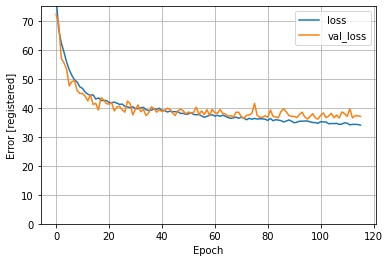

In [146]:
# define a function to plot the loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 75])
  plt.xlabel('Epoch')
  plt.ylabel('Error [registered]')
  plt.legend()
  plt.grid(True)


plot_loss(trained)

In [116]:
! mkdir -p saved_model

In [140]:
model.save('saved_model/model')
files.download('saved_model/model')

INFO:tensorflow:Assets written to: saved_model/model/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [147]:
# test the model
test_result = model.evaluate(test_features, test_labels)
test_result

109/109 [==============================] - 0s 2ms/step - loss: 35.1376


35.137630462646484

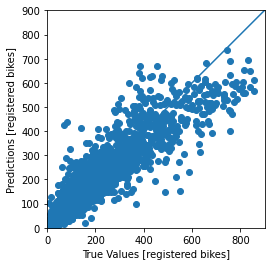

In [148]:
# plot the prediction line vs actual points
test_predictions = model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [registered bikes]')
plt.ylabel('Predictions [registered bikes]')
lims = [0, 900]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

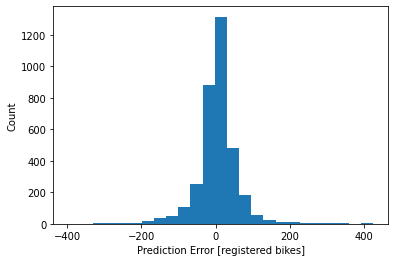

In [143]:
# plot the error distribution

error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [registered bikes]')
_ = plt.ylabel('Count')